In [1]:
import os
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
from utils import data_handler
from utils.models import vanilla_autoencoder


import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go



%load_ext tensorboard
!rm -rf ../workfiles/logs/

In [48]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(feature_selection_threshold = 5, 
                                                                        retain_phases="Both", 
                                                                        return_id= True,
                                                                        normalization = False,
                                                                        as_time_series = False,
                                                                        log1p = False,
                                                                        MT_removal = True)
                                                                    


Retaining patients that are included in phases 1 & 2
retaining all patient who have passed all visits...
loading samples...
loaded 1455 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
selecting genes based on median absolute deviation threshold:  5 ...
number of genes selected :  6172
number of seq in the dataset : 1455
keeping sample as is, no conversion to time series


In [49]:
importlib.reload(vanilla_autoencoder) # to allow modification of the script without restarting the whole session

latent_dim = 32

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [50]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=30, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=70)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [51]:
%tensorboard --logdir ../workfiles/logs/fit


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [52]:
hist = autoencoder.fit(x_train, epochs=2000, callbacks=cb) # around 2 hours

Epoch 1/2000
23/23 [==============================] - 9s 303ms/step - loss: 762346.9401 - lr: 0.0010
Epoch 2/2000
23/23 [==============================] - 5s 240ms/step - loss: 206416.1862 - lr: 0.0010
Epoch 3/2000
23/23 [==============================] - 5s 221ms/step - loss: 96958.8428 - lr: 0.0010
Epoch 4/2000
23/23 [==============================] - 5s 214ms/step - loss: 62116.8309 - lr: 0.0010
Epoch 5/2000
23/23 [==============================] - 5s 231ms/step - loss: 51591.1615 - lr: 0.0010
Epoch 6/2000
23/23 [==============================] - 5s 229ms/step - loss: 47760.3779 - lr: 0.0010
Epoch 7/2000
23/23 [==============================] - 5s 239ms/step - loss: 45145.9256 - lr: 0.0010
Epoch 8/2000
23/23 [==============================] - 6s 254ms/step - loss: 42191.4089 - lr: 0.0010
Epoch 9/2000
23/23 [==============================] - 5s 238ms/step - loss: 39024.2557 - lr: 0.0010
Epoch 10/2000
23/23 [==============================] - 5s 203ms/step - loss: 36383.8000 - lr: 0.00

Keeping in mind that outputting a constant solution for every observation yields a loss value of ~0.2 for MT removed, log1p transformed dataset.

In [53]:
autoencoder.load_weights(checkpoint_filepath)


[592561.375, 177429.0625, 85942.515625, 60302.91796875, 52137.9921875, 49055.24609375, 46181.13671875, 42778.328125, 39710.57421875, 37644.69140625, 36634.86328125, 39879.64453125, 35371.95703125, 34153.5234375, 31450.529296875, 29040.412109375, 28160.8046875, 25512.1875, 24469.69140625, 23284.84765625, 22718.318359375, 21036.173828125, 21629.439453125, 19099.470703125, 18541.44140625, 18976.451171875, 18183.484375, 14885.1328125, 14019.2646484375, 14012.5205078125, 14735.1328125, 15437.6064453125, 15790.337890625, 15679.517578125, 15504.8193359375, 15995.326171875, 16438.712890625, 16284.2216796875, 17397.271484375, 18147.69921875, 14610.8994140625, 12498.3310546875, 11550.705078125, 11346.0888671875, 11317.00390625, 11175.333984375, 11035.1494140625, 11036.7783203125, 11288.2978515625, 11495.939453125, 12023.48046875, 12865.298828125, 13019.9228515625, 13498.482421875, 13346.650390625, 12476.0517578125, 12151.93359375, 11322.173828125, 12140.1962890625, 13093.12890625, 11883.53125, 1

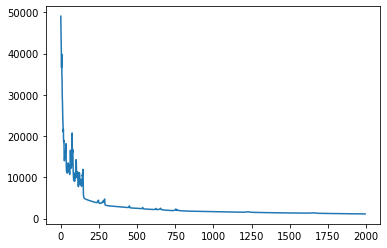

In [54]:
plt.plot(hist.history['loss'][5:])
print(hist.history['loss'])




### some diagnosis

In [55]:
e = iter(x_train).next()
z = autoencoder.encoder(e)
decoded = autoencoder.decoder(z)

In [56]:
e_ = e[0].reshape(1, -1) 
z_ = z[0].reshape(1, -1) 
decoded_ = decoded[0].reshape(1, -1) 



# Create subplot grid with vertical stacking
fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=False, vertical_spacing=0.1)

# Add the original image as a heatmap-like plot
heatmap_trace1 = go.Heatmap(z=e_, colorscale='viridis')
fig.add_trace(heatmap_trace1, row=1, col=1)

# Add the latent representation as a heatmap-like plot
heatmap_trace2 = go.Heatmap(z=z_, colorscale='viridis')
fig.add_trace(heatmap_trace2, row=2, col=1)

# Add the decoded image as a heatmap-like plot
heatmap_trace3 = go.Heatmap(z=decoded_, colorscale='viridis')
fig.add_trace(heatmap_trace3, row=3, col=1)

# Update layout
fig.update_layout(title='Stacked Graph of Image and Latent Space', showlegend=False)

# Update x-axis labels
#fig.update_xaxes(title_text='genes (normalized)', row=1, col=1)
#fig.update_xaxes(title_text='latent representation', row=2, col=1)
#fig.update_xaxes(title_text='genes (normalized)', row=3, col=1)

# Update y-axis labels
#fig.update_yaxes(title_text='timestamps', row=1, col=1)
#fig.update_yaxes(title_text='latent representation', row=2, col=1)
#fig.update_yaxes(title_text='timestamps', row=3, col=1)

fig.show()

In [57]:
autoencoder.encoder.save('../workfiles/simple_ae')


INFO:tensorflow:Assets written to: ../workfiles/simple_ae/assets


INFO:tensorflow:Assets written to: ../workfiles/simple_ae/assets


In [58]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

23/23 [==============================] - 0s 7ms/step


In [59]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [60]:
df.to_csv("../workfiles/processed_data_untransformed.csv", index=False)


# Viz Viz

In [61]:
import seaborn as sns

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



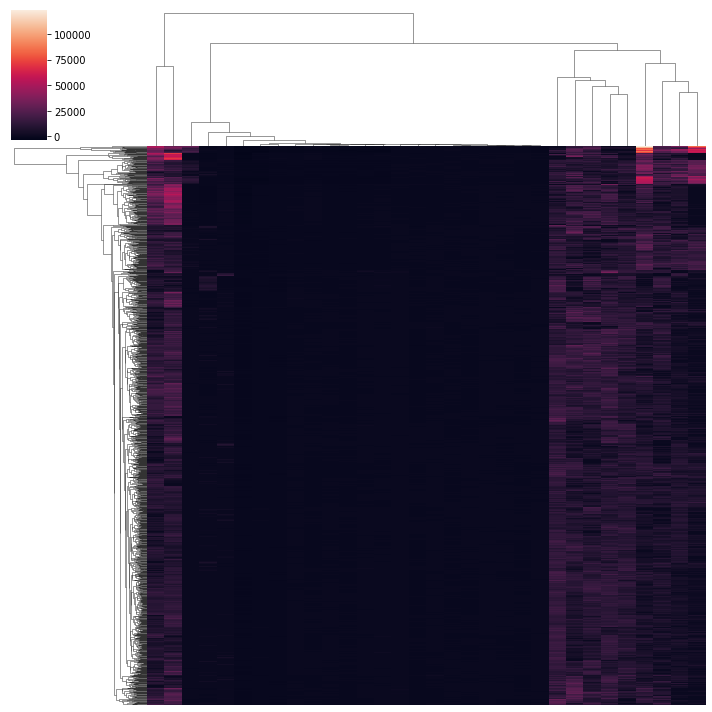

In [62]:
cluster_plot = sns.clustermap(compressed_dataframe,yticklabels=False,xticklabels=False)
cluster_plot

In [63]:
# let's reconstruct the dataset 
decoded = autoencoder.decoder.predict(compressed_dataframe)

46/46 [==============================] - 0s 3ms/step


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



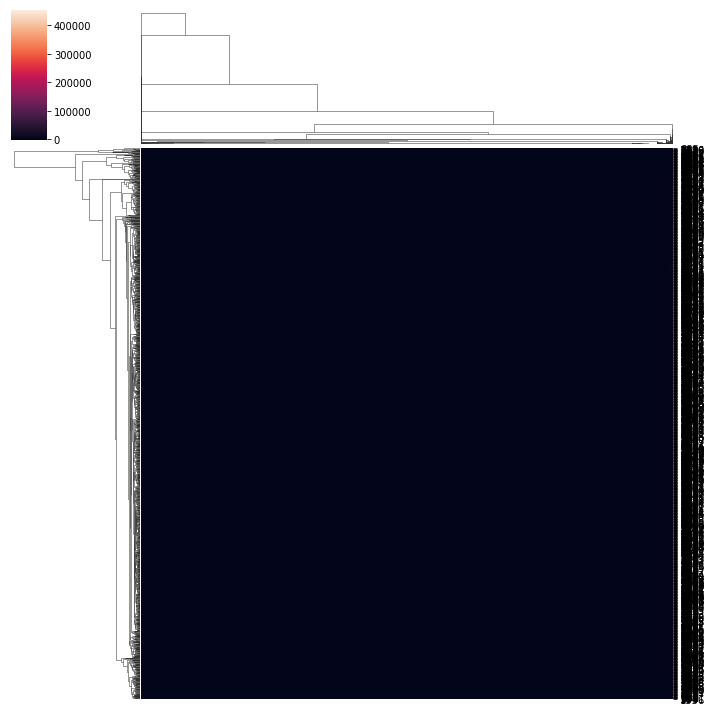

In [64]:
cluster_plot = sns.clustermap(decoded,yticklabels=True,xticklabels=False)
cluster_plot

way better results than with "tanh" ctivation function

In [21]:
# get everything out of TensorFlow back to numpy/pandas
data = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)
data = pd.DataFrame(data)
data.columns = gene_names
data.index = filenames

In [ ]:
cluster_plot = sns.clustermap(data,yticklabels=False,xticklabels=True)
cluster_plot